# CheXScan VGG-16 Model

## Libraries

In [1]:
import numpy as np
import os

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Tensorflow
import tensorflow as tf
import tensorflow_addons as tfa

# Keras
from keras import models, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications import VGG16

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

c:\Users\faith\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\faith\anaconda3\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

## Run this code if you're using Colab

from google.colab import drive
drive.mount('/content/drive/')

## Transform functions for data augmentation and normalization

You can further adjust these parameters if needed to achieve the desired balance between augmentation and maintaining image quality.

#### train_transform and test_transform

    Apply transformations to the input image for training data.

    Parameters:
        image (PIL.Image): Input image to be transformed.

    Returns:
        transformed_image (Tensor): Transformed image in tensor format.

In [2]:
train_transform = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),  # Adjust saturation and hue
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Dataset Summary

In [4]:
data_dir = r"E:/chexscan/data"
train_data_dir = os.path.join(data_dir, 'train_data')
test_data_dir = os.path.join(data_dir, 'test_data')

In [5]:
def count_images_in_subdirectories(directory):
    subdirectories = os.listdir(directory)
    counts = {}
    for subdir in subdirectories:
        subdir_path = os.path.join(directory, subdir)
        count = sum(len(files) for _, _, files in os.walk(subdir_path))
        counts[subdir] = count
    return counts

In [6]:
train_counts = count_images_in_subdirectories(train_data_dir)
test_counts = count_images_in_subdirectories(test_data_dir)

print("Number of images in each subdirectory of training data:")
for subdir, count in train_counts.items():
    print(f"{subdir}: {count}")

print("\nNumber of images in each subdirectory of testing data:")
for subdir, count in test_counts.items():
    print(f"{subdir}: {count}")

Number of images in each subdirectory of training data:
Normal: 800
Pneumonia: 800
Tuberculosis: 800

Number of images in each subdirectory of testing data:
Normal: 200
Pneumonia: 200
Tuberculosis: 200


## Define datasets (Online)

data_dir = '/content/drive/My Drive/THESIS/Datasets/Mary/'
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test_data'), transform=test_transform)

## Define datasets (Local)

In [7]:
data_dir = r"E:/chexscan/data"
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test_data'), transform=test_transform)

## Define data loaders

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Visualizes training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

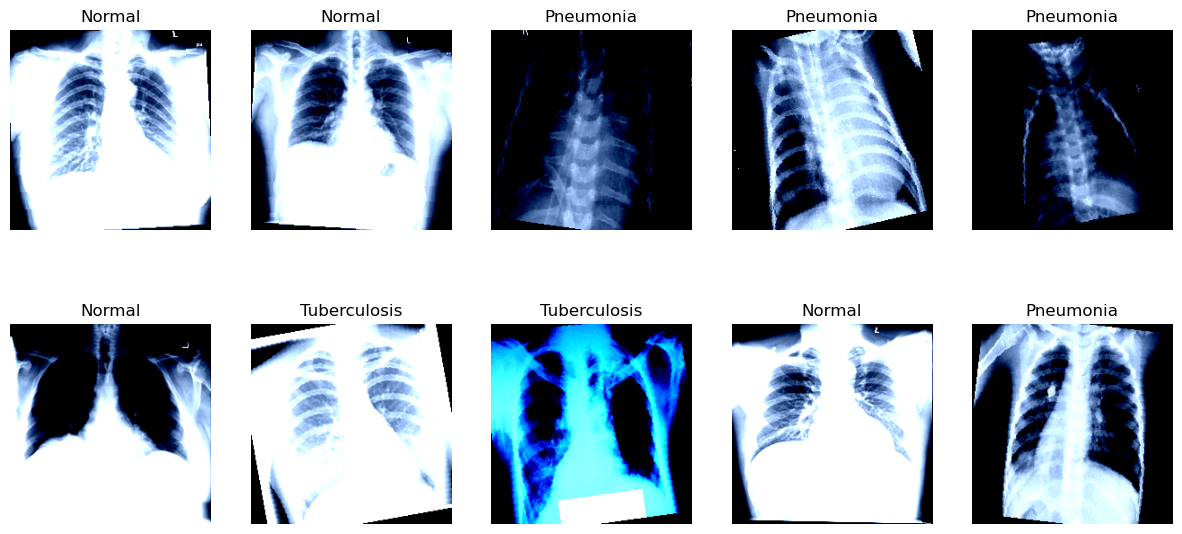

In [9]:
def visualize_training_data(loader):
    
    """
    Visualizes a batch of training images along with their corresponding labels.

    Parameters:
        loader (DataLoader): DataLoader containing the training dataset.

    Returns:
        None
    """
    
    classes = loader.dataset.classes
    class_names = {i: classes[i] for i in range(len(classes))}
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(figsize=(15, 7), ncols=5, nrows=2)
    for i, ax in enumerate(axes.flat):
        image = images[i].permute(1, 2, 0)
        ax.imshow(image)
        ax.set_title(class_names[labels[i].item()])
        ax.axis('off')
    plt.show()

visualize_training_data(train_loader)

# Define Callback Functions

In [10]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold_count):
        super(MyCallback, self).__init__()
        self.threshold_count = threshold_count
        self.consecutive_count = 0

    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            self.consecutive_count += 1
            if self.consecutive_count >= self.threshold_count:
                print("\nReached accuracy threshold 3 times! Terminating training.")
                self.model.stop_training = True
        else:
            self.consecutive_count = 0

# Define the callback with the threshold count
my_callback = MyCallback(threshold_count=3)

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss",
                                 patience=10)

# EarlyStopping callback to stop training if val_loss does not improve after n epochs
earlystop_cb = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

## Declaring class names

In [11]:
# Acquiring a list of all class names
class_names = os.listdir(train_data_dir)
n_classes = len(class_names)

print(class_names, n_classes)

['Normal', 'Pneumonia', 'Tuberculosis'] 3


## Define VGG-16 model

In [13]:
input_layer=layers.Input(shape=(224,224,3))

model = VGG16(weights='imagenet',
              input_tensor=input_layer,
              include_top=False)

last_layer=model.output

flatten=layers.Flatten()(last_layer)

output_layer=layers.Dense(n_classes,activation='softmax')(flatten)

model=models.Model(inputs=input_layer,outputs=output_layer)

# Making all the layers intrainable except the last layer
for layer in model.layers[:-1]:
    layer.trainable=False

### Declaring metrics and callbacks

In [14]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='acc'),
           tfa.metrics.F1Score(num_classes=n_classes)]

CALLBACKS = [my_callback, rop_callback, earlystop_cb]

### Compiling the model

In [15]:
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

## Define loss function and optimizer

In [22]:
criterion = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

## Move model to GPU if available

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Target Accuracy

In [18]:
desired_val_accuracy = 0.99

## Training the model

In [27]:
num_epochs = 25
BATCH_SIZE = 32
train_losses = []
val_losses = []
val_accuracies = []

In [36]:
import numpy as np
import torch
import tensorflow as tf

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.numpy()  # Convert PyTorch tensor to NumPy array
        inputs = np.transpose(inputs, (0, 2, 3, 1))  # Transpose the tensor to match the expected shape (batch_size, height, width, channels)
        labels = labels.numpy()
        with tf.GradientTape() as tape:
            outputs = model(inputs)
            loss = criterion(labels, outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        batch_size = len(inputs)  # Use len() to get batch size
        running_loss += loss.numpy() * batch_size  # Convert TensorFlow tensor to NumPy array

    epoch_loss = running_loss / len(train_data)
    train_losses.append(epoch_loss)

    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.numpy()
            inputs = np.transpose(inputs, (0, 2, 3, 1))  # Transpose the tensor to match the expected shape (batch_size, height, width, channels)
            labels = labels.numpy()
            outputs = model(inputs)
            loss = criterion(labels, outputs)
            val_loss += loss.numpy() * len(inputs)
            predicted = tf.math.argmax(outputs, axis=1)
            total += len(labels)
            correct += tf.reduce_sum(tf.cast(predicted == labels, tf.float32)).numpy()

    val_loss /= len(test_data)
    accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {accuracy:.4f}')


Epoch [1/25], Train Loss: 0.8243, Val Loss: 0.0986, Val Accuracy: 0.9883
Epoch [2/25], Train Loss: 0.7115, Val Loss: 0.3631, Val Accuracy: 0.9650
Epoch [3/25], Train Loss: 0.6384, Val Loss: 0.8516, Val Accuracy: 0.9500
Epoch [4/25], Train Loss: 0.7170, Val Loss: 0.4087, Val Accuracy: 0.9650
Epoch [5/25], Train Loss: 0.8780, Val Loss: 0.2354, Val Accuracy: 0.9850
Epoch [6/25], Train Loss: 0.4714, Val Loss: 0.2562, Val Accuracy: 0.9900
Epoch [7/25], Train Loss: 0.6241, Val Loss: 0.7376, Val Accuracy: 0.9583
Epoch [8/25], Train Loss: 0.5504, Val Loss: 0.3959, Val Accuracy: 0.9833
Epoch [9/25], Train Loss: 0.3375, Val Loss: 0.3838, Val Accuracy: 0.9817
Epoch [10/25], Train Loss: 0.4313, Val Loss: 0.3246, Val Accuracy: 0.9883
Epoch [11/25], Train Loss: 1.0096, Val Loss: 0.5159, Val Accuracy: 0.9683
Epoch [12/25], Train Loss: 0.7086, Val Loss: 0.4738, Val Accuracy: 0.9733
Epoch [13/25], Train Loss: 0.7749, Val Loss: 0.3484, Val Accuracy: 0.9850
Epoch [14/25], Train Loss: 0.5493, Val Loss: 0.

KeyboardInterrupt: 

## Model Accuracy for Training and Validation

In [ ]:
sns.set(style="whitegrid", rc={"axes.grid": True})

# Create a color palette
palette = sns.color_palette("husl", 2)

ax = ax.ravel()

sns.lineplot(x=history_vgg.epoch, y=history_vgg.history[metric], ax=ax[i], label="Train", color=palette[0])
sns.lineplot(x=history_vgg.epoch, y=history_vgg.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

ax.set_title(f"Model {metric.capitalize()}")
ax.set_xlabel("Epochs")
ax.set_ylabel(metric.capitalize())
ax.legend().set_visible(True)

plt.tight_layout()
plt.show()

## Plot validation accuracy

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

## Classification Report

In [ ]:
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

class_names = test_data.classes
print(classification_report(true_labels, predictions, target_names=class_names))

## Input function

In [ ]:
def predict_image(image_path, model):
    
    """
    Predicts the class of an input image using a trained model.

    Parameters:
        image_path (str): Path to the input image file.
        model (torch.nn.Module): Trained neural network model for image classification.

    Returns:
        predicted_class (str): Predicted class label for the input image.
    """
    
    image = Image.open(image_path)
    image = test_transform(image).unsqueeze(0)
    image = image.to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]
    return predicted_class

In [ ]:
# image_path = r"D:/Jupyter/chexscan-folder/chexscan/test/normal.png"
# predicted_class = predict_image(image_path, model)
# print(f'Predicted class: {predicted_class}')

In [ ]:
# image_path = r"D:/Jupyter/chexscan-folder/chexscan/test/pneumonia.jpeg"
# predicted_class = predict_image(image_path, model)
# print(f'Predicted class: {predicted_class}')

In [ ]:
# image_path = r"D:/Jupyter/chexscan-folder/chexscan/test/tb.png"
# predicted_class = predict_image(image_path, model)
# print(f'Predicted class: {predicted_class}')

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
def predict(image_path):
    image = Image.open(image_path)
    image = test_transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()